# Automated Design of Agentic Systems (ADAS)

Automated Design of Agentic Systems (ADAS) is a [paper by Hu et al.](https://arxiv.org/pdf/2408.08435) which was one of the first works to explore the idea of automatically designing agentic systems:

>Automated Design of Agentic Systems (ADAS) [...] aims to automatically create powerful agentic system designs, including inventing novel building blocks
and/or combining them in new ways.

The idea of ADAS is that instead of using hand-crafted prompting techniques like LLM debate, a meta agent designs novel agents using code. This agent is then tested on a task and the results are given back to the meta agent to further guide its search for a design.

![](assets/adas.png)

```
@article{hu2024ADAS,
title={Automated Design of Agentic Systems},
author={Hu, Shengran and Lu, Cong and Clune, Jeff},
journal={arXiv preprint arXiv:2408.08435},
year={2024}
}
```

This notebook shows how to implement their ideas using the agenticblocks framework.

To implement ADAS we need to build the following:

1. The meta agent which has the task to design agentic systems. We give it access to the built-in blocks of agenticblocks and ask it to come up with novel blocks and / or combine them in new ways.
2. A way of testing the designs found by the meta agent, so it can use the feedback as input for new designs. For demonstration purposes we will use a small sample of the [MMLU-STEM Dataset](https://huggingface.co/datasets/TIGER-Lab/MMLU-STEM), containing multiple choice questions from academic exams and textbooks in the STEM domain.

## Setup

### Imports

Besides some built-in python libraries, we import the agenticblocks library to define the agentic system, pyarrow to read the MMLU dataset, numpy and matplotlib to compute and plot metrics and tqdm to show progress.

In [ ]:
import inspect
import io
import json
import urllib.request
import traceback

import agenticblocks as ab
import matplotlib.pyplot as plt
import numpy as np
import pyarrow.parquet as pq
from tqdm.auto import tqdm

/Users/robin/projects/agenticblocks/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This example involves running model-generated code. If you set `YOLO = False` you will be prompted to review and accept any model-generated code before it is executed.

In [ ]:
YOLO = False

### Model Access

We need to set up access to the language model(s) we want to use.
agenticblocks supports all OpenAI API compatible providers.

You can set the base url and api key via the `OPENAI_API_URL` and `OPENAI_API_KEY` environment variables.

For more details check the [getting started example](01_getting_started.ipynb).

In [3]:
#import dotenv
#dotenv.load_dotenv()

#!export OPENAI_API_URL=
#!export OPENAI_API_KEY=

We also define the models we are going to use throughout this notebook.
For this example we will use gpt-4o for the meta agent and gpt-3.5-turbo as the agent in the discovered blocks.

In [4]:
META_MODEL_NAME = "openai/gpt-4o"
BLOCK_MODEL_NAME = "openai/gpt-3.5-turbo"

### Data

Let's download the MMLU STEM dataset from Hugging Face.

We will use a small subset of 50 examples for providing feedback to the meta agent on how well the discovered block perfomed.

In [5]:
n_samples = 50
url = "https://huggingface.co/datasets/TIGER-Lab/MMLU-STEM/resolve/main/data/test-00000-of-00001.parquet"

with urllib.request.urlopen(url) as response:
    data = io.BytesIO(response.read())

df = pq.read_table(data).to_pandas().sample(n_samples, random_state=1).reset_index(drop=True)

In [6]:
def format_input(row):
    return f"""{row['question']}

{chr(10).join([f"{chr(ord('A')+i)}) {choice}" for i, choice in enumerate(row['choices'])])}
"""

df["input"] = df.apply(format_input, axis=1)

In [7]:
print(df["input"].iloc[0])

Statement 1 | For any two groups G and G', there exists a homomorphism of G into G'. Statement 2 | Every homomorphism is a one-to-one map.

A) True, True
B) False, False
C) True, False
D) False, True



## The Meta Agent

The meta agent itself is just an instance of the agenticblocks `Model` class. The same class the agent will be use to create its models.

In [8]:
meta_agent = ab.Model(
    META_MODEL_NAME,
    keep_history=True,
)

We also need to define the prompt for the meta agent. In the prompt we let the meta agent know ...
* about its task - building an agentic system to answer MMLU questions
* what tools it can use to build these systems - python code and the agenticblocks framework
* how its blocks will be evaluated on the dataset
* how its previous solutions performed by using an "archive"

In [9]:
blocks = [ab.IO, ab.ChainOfThought, ab.SelfConsistency, ab.MultiAgentDebate, ab.SelfRefine]

In [10]:
prompt = f"""# Overview
You are an expert machine learning researcher testing various agentic systems. Your objective is to design building blocks such as prompts and control flows within these systems to solve complex tasks. Your aim is to design an optimal agent performing well on the MMLU (Massive Multitask Language Understanding) benchmark, a challenging evaluation that assesses a model's ability to answer questions across a wide range of subjects and difficulty levels. It includes subjects from STEM, social sciences, humanities, and more.

## An example question from MMLU:
The constellation ... is a bright W-shaped constellation in the northern sky.

A) Centaurus
B) Cygnus
C) Cassiopeia
D) Cepheus

# How to implement your agentic systems
You can use the agenticblocks library to create and manage models:

```python
import agenticblocks as ab
model = ab.Model("{BLOCK_MODEL_NAME}", system_prompt="You are a helpful assistant.")
```

Always use the {BLOCK_MODEL_NAME} model when you create a new model.
A model can be prompted in the following way:

```python
model("Your prompt here", temperature=0.7)
```

blocks define how models are prompted and how they interact with each other.
agenticblocks offers some built-in blocks that you can use to create agentic systems:

```python
{'\n\n\n'.join([inspect.getsource(block) for block in blocks])}
```

The built-in blocks can be imported using `from agenticblocks import BlockName`.
You can use these blocks as building blocks to combine them to new blocks or use them as inspiration to design your own blocks.

# Discovered architecture archive
Here is the archive of the built-in blocks and discovered architectures:

[ARCHIVE]

The fitness value is the median and 95% Bootstrap Confidence Interval of the correct rate on a validation question set. Your GOAL is to maximize the "fitness".

# Output Instruction and Example:
You need to output a JSON object with three keys: "thought", "name", and "code".
The first key should be ("thought"), and it should capture your thought process for designing the next function. In the "thought" section, first reason about what should be the next interesting agent to try, then describe your reasoning and the overall concept behind the agent design, and finally detail the implementation steps.
The second key ("name") corresponds to the class name of your next agent architecture. Make sure the name is unique and descriptive of the architecture you are proposing. 
Finally, the last key ("code") corresponds to the exact Python code of the class that you would like to try. You must write a COMPLETE CODE in "code": Your code will be part of the entire project, so please implement complete, reliable, reusable code snippets.

Here is an example of the output format for the next agent architecture:

{{
    "thought": "**Insights:**\nYour insights on what should be the next interesting agent.\n**Overall Idea:**\nyour reasoning and the overall concept behind the agent design.\n**Implementation:**\ndescribe the implementation step by step.",
    "name": "YourCustomAgenticBlock",
    "code": '''class YourCustomAgenticBlock:
    def __init__(self):
        # Your code here

    def __call__(self, question):
        # Your code here
'''
}}

You must use the exact interface used above. You need to specify the instruction, input information, and the required output fields for various LLM agents to do their specific part of the architecture. 
Also, it could be helpful to set the LLM’s system_prompt and temperature to further control the LLM’s response. Note that only the question will be passed to the instance of the block class. Everything else needs to be already implemented in the __init__ and __call__ methods of the block class.
DO NOT FORGET to pass the task description to models inside the block class if you think it is needed, otherwise the models will not know about the task.

The key "code" from your output JSON will be saved to a custom_blocks.py file and will be called like this:

```python
from custom_blocks import YourCustomAgenticBlock

question = '''The constellation ... is a bright W-shaped constellation in the northern sky.

A) Centaurus
B) Cygnus
C) Cassiopeia
D) Cepheus
'''

block = YourCustomAgenticBlock()
result = block(question)
```

# Your task
You are deeply familiar with LLM prompting techniques and LLM agent works from the literature. Your goal is to maximize "fitness" by proposing interestingly new agents. 
Observe the discovered architectures carefully and think about what insights, lessons, or stepping stones can be learned from them.
Be creative to think about the next interesting architecture to try. You are encouraged to draw inspiration from related LLM agent papers or academic papers from other research areas.
Using the knowledge learned from the archive and the inspiration from academic literature to give the next interesting architecture.
THINK OUTSIDE THE BOX.
"""

We will prompt the meta agent in a self refining manner. That means we ask it one time to reflect on its design and improve it.

In [11]:
reflection_template = """"{previous_response}Carefully review the proposed new architecture and reflect on the following points:"

1. **Interestingness**: Assess whether your proposed architecture is interesting or innovative compared to existing methods in the archive. If you determine that the proposed architecture is not interesting, suggest a new architecture that addresses these shortcomings. 
- Make sure to check the difference between the proposed architecture and previous attempts.
- Compare the proposal and the architectures in the archive CAREFULLY, including their actual differences in the implementation.
- Decide whether the current architecture is innovative.
- USE CRITICAL THINKING!

2. **Implementation Mistakes**: Identify any mistakes you may have made in the implementation. Review the code carefully, debug any issues you find, and provide a corrected version. REMEMBER checking "## WRONG Implementation examples" in the prompt.

3. **Improvement**: Based on the proposed architecture, suggest improvements in the detailed implementation that could increase its performance or effectiveness. In this step, focus on refining and optimizing the existing implementation without altering the overall design framework, except if you want to propose a different architecture if the current is not interesting.
- Observe carefully about whether the implementation is actually doing what it is supposed to do.
- Check if there is redundant code or unnecessary steps in the implementation. Replace them with effective implementation.
- Try to avoid the implementation being too similar to the previous agent.

And then, you need to improve or revise the implementation, or implement the new proposed architecture based on the reflection.

Your response should be organized as follows:

"reflection": Provide your thoughts on the interestingness of the architecture, identify any mistakes in the implementation, and suggest improvements.

"thought": Revise your previous proposal or propose a new architecture if necessary, using the same format as the example response.

"name": Provide a name for the revised or new architecture. (Don't put words like "new" or "improved" in the name.)

"code": Provide the corrected code or an improved implementation. Make sure you actually implement your fix and improvement in this code.
"""

This is an adjusted prompt from the [ADAS repo](https://github.com/ShengranHu/ADAS).

For simplicity, we tell the meta agent to always use the `MODEL_NAME` defined above for its blocks.
If you have more models available, you can modify the prompt to let the meta agent decide which models it wants to use.

We also show the meta agent the built in blocks and how it can design its own blocks.

The archive is initialized by evaluating the built in blocks on the data.

In [12]:
# function to evaluate a block on the mmlu dataset
def eval_block(block, df):
    answers = []
    for question in df["input"]:
        response = block(f"{question}\n\nThe last line of your answer should be the correct choice, e.g. A)")["content"]
        answer = None
        for line in response.splitlines():
            if answer is not None:
                break
            for k, v in {"A)": 0, "B)": 1, "C)": 2, "D)": 3}.items():
                if k in line:
                    answer = v
                    break
        answers += [answer]
    df[str(block)] = answers
    # bootstrap score
    acc_list = (df["answer"] == df[str(block)]).astype(int)
    scores = []
    for _ in range(1000):
        scores += [np.mean(np.random.choice(acc_list, len(acc_list), replace=True))]
    return np.percentile(scores, 2.5), np.percentile(scores, 97.5), np.median(scores)

In [13]:
# build the initial archive by evaluating the built-in blocks on the train set
archive = []
for block_class in tqdm(blocks, total=len(blocks)):
    model = ab.Model(BLOCK_MODEL_NAME)
    if block_class == ab.MultiAgentDebate:
        block = block_class(agents=[model]*3)
    else:
        block = block_class(model)
    ci_lo, ci_hi, med = eval_block(block, df)
    archive += [{
        "name": f"ab.{block_class.__name__}",
        "thought": "agenticblocks built-in",
        "code": inspect.getsource(block_class),
        "fitness": {"95% Bootstrap Confidence Interval": f"({ci_lo*100:.1f}%, {ci_hi*100:.1f}%)", "median": round(med*100, 1)},
    }]

100%|██████████| 5/5 [16:02<00:00, 192.46s/it]


In [14]:
archive

[{'name': 'ab.IO',
  'thought': 'agenticblocks built-in',
  'code': 'class IO:\n    """IO block - simple pass-through to the model."""\n\n    def __init__(self, model):\n        self.model = model\n\n    def __repr__(self):\n        return f"IO({self.model!r})"\n\n    def __call__(self, prompt: str, **kwargs) -> dict:\n        return self.model(prompt, **kwargs)\n',
  'fitness': {'95% Bootstrap Confidence Interval': '(36.0%, 64.0%)',
   'median': np.float64(50.0)}},
 {'name': 'ab.ChainOfThought',
  'thought': 'agenticblocks built-in',
  'code': 'class ChainOfThought:\n    """Chain of Thought block - prompts the model to think step by step."""\n\n    def __init__(self, model, template: str = "{prompt}\\nLet\'s think step by step."):\n        self.model = model\n        self.template = template\n\n    def __repr__(self):\n        return f"ChainOfThought({self.model!r})"\n\n    def __call__(self, prompt: str, **kwargs) -> dict:\n        return self.model(self.template.format(prompt=prompt

Now let's use the prompts to let the meta agent search for new blocks, evaluate them on the mmlu dataset and append new blocks to the archive.

For demonstration purposes we do this for 15 rounds. For better results add more rounds - in the ADAS paper 25 iterations are used.

If the code produced by the meta agent throws an exception we ask it up to 5 times to fix it.

If you notice the meta agent keeps repeating a certain mistake or uses a bad pattern in the generated blocks you can adjust the prompt above and ask it to avoid these mistakes.

With `YOLO = False`, you need to confirm each new block before it is evaluated on the dataset.

In [15]:
n_iters = 15
for iter in range(n_iters):
    print("="*30, f"Round {iter+1} of {n_iters}", "="*30)
    meta_agent.reset_history()  # reset the models message history
    response = meta_agent(prompt.replace("[ARCHIVE]", json.dumps(archive)))
    response = meta_agent(reflection_template.format(previous_response=json.dumps(response)))

    success = False
    for retry in range(5):
        try:
            # Parse JSON response
            response_parsed = json.loads(response["content"].split('```json\n')[-1].split('\n```')[0])
            
            # Review mode: show code and ask for approval
            if not YOLO:
                print(f"\n{response_parsed['name']}:\n{response_parsed['code']}\n")
                if input("Run? [Y/n]: ").strip().lower() == 'n':
                    break
            
            # Execute the code
            namespace = globals().copy()
            exec(response_parsed["code"], namespace)
            NewBlock = namespace[response_parsed["name"]]
            block = NewBlock()
            ci_lo, ci_hi, med = eval_block(block, df)
            success = True
            break
            
        except Exception as e:
            print(f"Error (attempt {retry + 1}/3): {e}")
            response = meta_agent(f"The following exception occurred when trying to test the block: {e}. Traceback: {traceback.format_exc()}. Return a valid JSON with keys name, code, thought and reflection. The name is the class name of the found block, code contains the fixed implementation of the block, thought as before the thought process behind the block design and reflection your reflection on the exception.")

    if success:
        result = {
            "name": NewBlock.__name__,
            "thought": response_parsed["thought"],
            "code": response_parsed["code"],
            "fitness": {"95% Bootstrap Confidence Interval": f"({ci_lo*100:.1f}%, {ci_hi*100:.1f}%)", "median": round(med*100, 1)},
        }
        archive += [result]
        print("Successfully found a new block:")
        print(json.dumps(result, indent=4))

============================== Round 1 of 15 ==============================
Error (attempt 1/3): Expecting ',' delimiter: line 5 column 15 (char 2489)
Successfully found a new block:
{
    "name": "RefinedAdaptiveDynamicStrategy",
    "thought": "**Insights:**\nThe dynamic agent design leveraging adaptability in selecting strategies based on question complexity is compelling. Its hypothesis is rooted in adapting to varying levels of question difficulty using different models, improving response accuracy and efficiency. However, it's clear from the reflected issue that detailed attention on JSON structure for responses is vital.\n\n**Overall Idea:**\nAddress the JSON encoding error found in the previous implementation while maintaining the design principle that involves assessing the question's complexity dynamically, caching results, and adjusting methodology accordingly to deliver optimal responses based on complexity and confidence levels.\n\n**Implementation:**\nTo prevent such issu

<string>:15: RuntimeWarning: invalid value encountered in scalar divide


Successfully found a new block:
{
    "name": "SemanticKnowledgeAugmentedAgent",
    "thought": "**Insights:**\nThe integration of semantic similarity for knowledge retrieval can substantially enrich language models by deriving contextually relevant information, but relying on external libraries such as `sentence_transformers` introduces dependency issues. Addressing this, we can design an internal mechanism for semantic checking using cosine similarity on manually defined embeddings or keywords.\n\n**Overall Idea:**\nTo develop a self-contained semantic similarity process that does not depend on external libraries, a pre-defined list of keywords will be used to simulate semantic augmentation. This results in a simpler but integrated agent, providing more robust responses by broadening its informational scope.\n\n**Implementation:**\n1. Define a simple method to compare semantic relevance between prompt keywords and the knowledge base without external dependencies.\n2. Implement cosine

In [27]:
# best discovered block
best_score = 0
best_block = None
for block in archive:
    if block["fitness"]["median"] > best_score:
        best_score = block["fitness"]["median"]
        best_block = block

print(best_block["name"], "- Score: ", best_block["fitness"]["median"], end="\n\n")
print(best_block["thought"], end="\n\n")
print(best_block["code"])

AdaptiveWeightedConsensusAgent - Score:  64.0

**Insights:**
While existing ensemble-like architectures with multi-agent debate strategies are prevalent, enhancing decision fusion with intricate weight adjustments and dynamic role adaptability—using context evaluations and precedent decision efficiencies—can further refine results. We reflect on the importance of leveraging a dynamic, adaptive weighting system that recalculates based on empirical feedback loop mechanisms.

**Overall Idea:**
The revised 'AdaptiveWeightedConsensusAgent' focuses on improving the voting mechanism where contextually driven weights influence the consensus decision. Roles contribute differently based on previous efficacies and gain current evaluation scaling within their strategic utility framework, enhancing overall decision integrity.

**Implementation:**
1. Implement a complex weighting mechanism for each role influenced by evaluated response confidence scores, dynamically adjusted.
2. Use a context learne

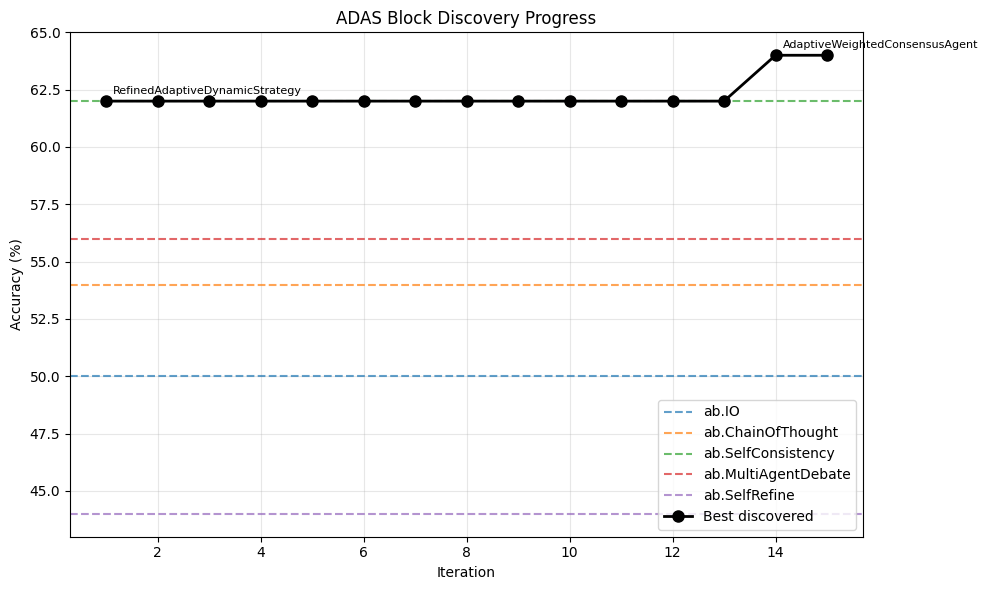

In [ ]:
# plot block discovery progress

medians = [float(item['fitness']['median']) for item in archive]
is_builtin = [item['thought'] == 'agenticblocks built-in' for item in archive]

builtin_items = [(item['name'], float(item['fitness']['median'])) for item in archive if item['thought'] == 'agenticblocks built-in']
discovered_items = [(item['name'], float(item['fitness']['median'])) for item in archive if item['thought'] != 'agenticblocks built-in']

best_so_far = []
best_names = []
current_best = 0
current_best_name = ''
for name, score in discovered_items:
    if score > current_best:
        current_best = score
        current_best_name = name
    best_so_far.append(current_best)
    best_names.append(current_best_name if score >= current_best else None)

plt.figure(figsize=(10, 6))
colors = plt.cm.tab10.colors
for i, (name, score) in enumerate(builtin_items):
    plt.axhline(y=score, linestyle='--', alpha=0.7, color=colors[i], label=name)

iterations = range(1, len(best_so_far) + 1)
plt.plot(iterations, best_so_far, 'ko-', linewidth=2, markersize=8, label='Best discovered')
for i, name in enumerate(best_names):
    if name and (i == 0 or best_so_far[i] > best_so_far[i-1]):
        plt.annotate(name, (i+1, best_so_far[i]), textcoords="offset points", 
                     xytext=(5, 5), fontsize=8)

plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.title('ADAS Block Discovery Progress')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()